<a href="https://colab.research.google.com/github/SiddharthPany/artificial-intelligence/blob/master/session9/Session9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


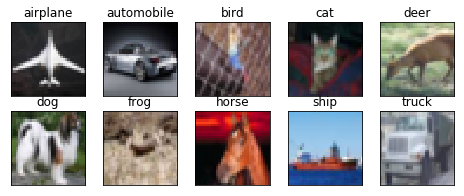

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)
  
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [5]:
from keras.regularizers import l2

weight_decay = 1e-4
# Define the model
model = Sequential()

# Convolution layer - 1
model.add(Convolution2D(16,(3, 3), padding="same", kernel_regularizer=l2(weight_decay), input_shape=(32, 32, 3)))  #  RF : 3  image-size = 32*3*3
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))

model.add(Convolution2D(32,(3, 3), padding='same', kernel_regularizer=l2(weight_decay)))  # RF : 5
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))

model.add(Convolution2D(64,(3, 3), padding='same', kernel_regularizer=l2(weight_decay)))   # RF : 7
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))

model.add(Convolution2D(128,(3, 3), padding='same', kernel_regularizer=l2(weight_decay)))  # RF : 9
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))

model.add(Convolution2D(256,(3, 3), padding='same', kernel_regularizer=l2(weight_decay)))  #  RF : 11
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))

# Transition Layer - 1
model.add(Convolution2D(10,(1, 1), activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))   #   RF : 22  image-size = 16*3*3
model.add(Dropout(0.10))

# Convolution layer - 2
model.add(Convolution2D(16,(3, 3), padding="same", kernel_regularizer=l2(weight_decay), input_shape=(32, 32, 3)))  #  RF : 3  image-size = 32*3*3
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))

model.add(Convolution2D(32,(3, 3), padding='same', kernel_regularizer=l2(weight_decay)))  # RF : 5
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))

model.add(Convolution2D(64,(3, 3), padding='same', kernel_regularizer=l2(weight_decay)))   # RF : 7
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))

model.add(Convolution2D(128,(3, 3), padding='same', kernel_regularizer=l2(weight_decay)))  # RF : 9
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))

model.add(Convolution2D(256,(3, 3), padding='same', kernel_regularizer=l2(weight_decay)))  #  RF : 11
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))

# Transition Layer - 2
model.add(Convolution2D(10,(1, 1), activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))   #   RF : 22  image-size = 8*3*3
model.add(Dropout(0.10))

# Convolution layer - 3
model.add(Convolution2D(16, 3, 3, kernel_regularizer=l2(weight_decay)))  #  RF : 24  image-size = 6
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))

model.add(Convolution2D(32, 3, 3, kernel_regularizer=l2(weight_decay)))  # RF : 26   image-size = 4
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.10))

# Transition Layer - 3
model.add(Convolution2D(10, 4, 4))

model.add(Flatten())
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

W0627 09:44:33.918336 140034366793600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 09:44:33.932838 140034366793600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 09:44:33.936377 140034366793600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 09:44:33.965487 140034366793600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0627 09:44:33.966386 1400343667

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
__________

In [0]:
# Saving model to collab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  app.launch_new_instance()
W0627 10:25:53.184604 140034366793600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.

Epoch 1/50
390/390 [==============================] - 62s 158ms/step - loss: 1.8865 - acc: 0.3297 - val_loss: 2.0227 - val_acc: 0.3565
Epoch 2/50
390/390 [==============================] - 56s 143ms/step - loss: 1.5527 - acc: 0.4540 - val_loss: 1.5574 - val_acc: 0.4745
Epoch 3/50
390/390 [==============================] - 55s 140ms/step - loss: 1.4187 - acc: 0.5095 - val_loss: 1.2741 - val_acc: 0.5675
Epoch 4/50
390/390 [==============================] - 55s 140ms/step - loss: 1.3374 - acc: 0.5431 - val_loss: 1.1677 - val_acc: 0.5979
Epoch 5/50
390/390 [==============================] - 55s 140ms/step - loss: 1.2669 - acc: 0.5751 - val_loss: 1.4157 - val_acc: 0.5580
Epoch 6/50
390/390 [==============================] - 55s 140ms/step - loss: 1.2147 - acc: 0.5935 - val_loss: 1.2045 - val_acc: 0.6142
Epoch 7/50
390/390 [==============================] - 55s 140ms/step - loss: 1.1594 - acc: 0.6159 - val_loss: 1.1036 - val_acc: 0.6492
Epoch 8/50
390/390 [==============================] - 5

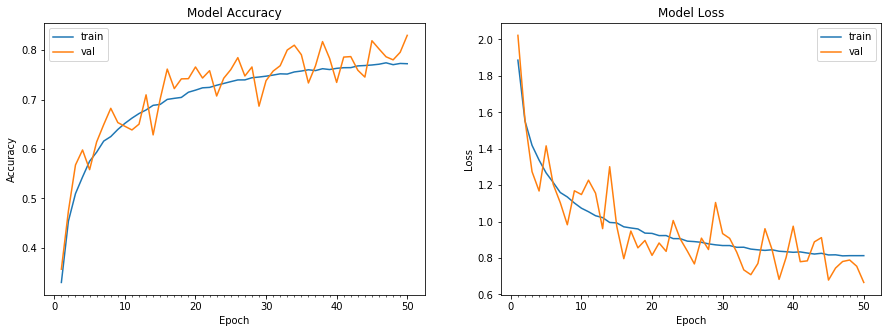

Accuracy on test data is: 82.99


In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

datagen = ImageDataGenerator(zoom_range=0.0,
                             rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level='false'))

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks=[LearningRateScheduler(lr_schedule)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))